# Test Out wav_read on OGG files

In [5]:
import numpy as np
import resampy

import mel_features
import vggish_params

In [6]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib

In [13]:
ogg_file = "/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018/audio-ogg/000/000046_3840.ogg"

In [10]:
cd sagemaker-studiolab-notebooks

/home/studio-lab-user/sagemaker-studiolab-notebooks


In [9]:
try:
  import soundfile as sf

  def wav_read(wav_file):
    wav_data, sr = sf.read(wav_file, dtype='int16')
    return wav_data, sr

except ImportError:
  def wav_read(wav_file):
    raise NotImplementedError('WAV file reading requires soundfile package.')

In [12]:
wav_read(ogg_file)

(array([[    0,     0],
        [    0,     0],
        [    0,     0],
        ...,
        [-3068, -7416],
        [-3293, -7726],
        [-3015, -7698]], dtype=int16),
 44100)

In [13]:
scale, sampling_rate = librosa.load(ogg_file)

# Test out wavfile_to_examples on OGG files

In [10]:
import vggish_slim
import vggish_params
import vggish_input

In [11]:
import numpy as np
import vggish_postprocess

In [12]:
def waveform_to_examples(data, sample_rate):
  """Converts audio waveform into an array of examples for VGGish.

  Args:
    data: np.array of either one dimension (mono) or two dimensions
      (multi-channel, with the outer dimension representing channels).
      Each sample is generally expected to lie in the range [-1.0, +1.0],
      although this is not required.
    sample_rate: Sample rate of data.

  Returns:
    3-D np.array of shape [num_examples, num_frames, num_bands] which represents
    a sequence of examples, each of which contains a patch of log mel
    spectrogram, covering num_frames frames of audio and num_bands mel frequency
    bands, where the frame length is vggish_params.STFT_HOP_LENGTH_SECONDS.
  """
  # Convert to mono.
  if len(data.shape) > 1:
    data = np.mean(data, axis=1)
  # Resample to the rate assumed by VGGish.
  if sample_rate != vggish_params.SAMPLE_RATE:
    data = resampy.resample(data, sample_rate, vggish_params.SAMPLE_RATE)

  # Compute log mel spectrogram features.
  log_mel = mel_features.log_mel_spectrogram(
      data,
      audio_sample_rate=vggish_params.SAMPLE_RATE,
      log_offset=vggish_params.LOG_OFFSET,
      window_length_secs=vggish_params.STFT_WINDOW_LENGTH_SECONDS,
      hop_length_secs=vggish_params.STFT_HOP_LENGTH_SECONDS,
      num_mel_bins=vggish_params.NUM_MEL_BINS,
      lower_edge_hertz=vggish_params.MEL_MIN_HZ,
      upper_edge_hertz=vggish_params.MEL_MAX_HZ)

  # Frame features into examples.
  features_sample_rate = 1.0 / vggish_params.STFT_HOP_LENGTH_SECONDS
  example_window_length = int(round(
      vggish_params.EXAMPLE_WINDOW_SECONDS * features_sample_rate))
  example_hop_length = int(round(
      vggish_params.EXAMPLE_HOP_SECONDS * features_sample_rate))
  log_mel_examples = mel_features.frame(
      log_mel,
      window_length=example_window_length,
      hop_length=example_hop_length)
  return log_mel_examples


def wavfile_to_examples(wav_file):
  """Convenience wrapper around waveform_to_examples() for a common WAV format.

  Args:
    wav_file: String path to a file, or a file-like object. The file
    is assumed to contain WAV audio data with signed 16-bit PCM samples.

  Returns:
    See waveform_to_examples.
  """
  wav_data, sr = wav_read(wav_file)
  assert wav_data.dtype == np.int16, 'Bad sample type: %r' % wav_data.dtype
  samples = wav_data / 32768.0  # Convert to [-1.0, +1.0]
  return waveform_to_examples(samples, sr)

In [15]:
example = vggish_input.wavfile_to_examples(ogg_file)

In [64]:
example[9]

array([[ 2.51149453,  2.60651203,  1.96133896, ..., -0.521486  ,
        -0.08668707,  0.56043407],
       [ 2.34245532,  2.46880769,  1.74214255, ..., -0.20441542,
        -0.13434715, -0.17198743],
       [ 2.36846426,  2.47827471,  1.8040517 , ..., -0.04506807,
         0.16628694,  0.38816167],
       ...,
       [ 2.32895718,  2.87466782,  2.54148587, ..., -0.47428836,
        -0.35848927, -0.57632454],
       [ 2.69073276,  2.9098468 ,  2.44787603, ..., -0.43853564,
        -0.50331557, -0.66511921],
       [ 2.39707648,  2.81003938,  2.3965639 , ..., -0.03917692,
        -0.55333859, -0.42275099]])

In [21]:
example.shape

(10, 96, 64)

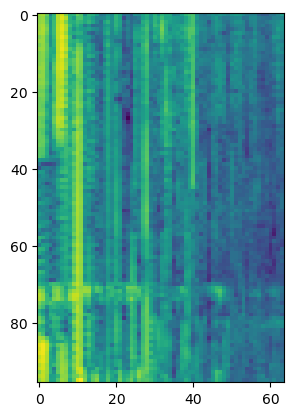

In [66]:
import matplotlib.pyplot as plt
plt.imshow(example[9])

In [5]:
def CreateVGGishNetwork(hop_size=0.96):   # Hop size is in seconds.
  """Define VGGish model, load the checkpoint, and return a dictionary that points
  to the different tensors defined by the model.
  """
  vggish_slim.define_vggish_slim()
  checkpoint_path = 'vggish_model.ckpt'
  vggish_params.EXAMPLE_HOP_SECONDS = hop_size
  vggish_slim.load_vggish_slim_checkpoint(sess, checkpoint_path)
  features_tensor = sess.graph.get_tensor_by_name(
      vggish_params.INPUT_TENSOR_NAME)
  embedding_tensor = sess.graph.get_tensor_by_name(
      vggish_params.OUTPUT_TENSOR_NAME)
  layers = {'conv1': 'vggish/conv1/Relu',
            'pool1': 'vggish/pool1/MaxPool',
            'conv2': 'vggish/conv2/Relu',
            'pool2': 'vggish/pool2/MaxPool',
            'conv3': 'vggish/conv3/conv3_2/Relu',
            'pool3': 'vggish/pool3/MaxPool',
            'conv4': 'vggish/conv4/conv4_2/Relu',
            'pool4': 'vggish/pool4/MaxPool',
            'fc1': 'vggish/fc1/fc1_2/Relu',
            #'fc2': 'vggish/fc2/Relu',
            'embedding': 'vggish/embedding',
            'features': 'vggish/input_features',
         }
  g = tf.get_default_graph()
  for k in layers:
    layers[k] = g.get_tensor_by_name( layers[k] + ':0')
  return {'features': features_tensor,
          'embedding': embedding_tensor,
          'layers': layers,
         }

In [6]:
def ProcessWithVGGish(vgg, file_path):
  '''Run the VGGish model, starting with an audio file with path file_path. 
  Return a whitened version of the embeddings. Sound must be scaled to be
  floats between -1 and +1.'''
  # Produce a batch of log mel spectrogram examples.
  input_batch = vggish_input.wavfile_to_examples(file_path)
  # print('Log Mel Spectrogram example: ', input_batch[0])
  [embedding_batch] = sess.run([vgg['embedding']],
                               feed_dict={vgg['features']: input_batch})
  # Postprocess the results to produce whitened quantized embeddings.
  pca_params_path = 'vggish_pca_params.npz'
  pproc = vggish_postprocess.Postprocessor(pca_params_path)
  postprocessed_batch = pproc.postprocess(embedding_batch)
  # print('Postprocessed VGGish embedding: ', postprocessed_batch[0])
  return postprocessed_batch[0]

In [11]:
# Test these new functions with the original test.
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

tf.reset_default_graph()

sess = tf.Session()

vgg = CreateVGGishNetwork(0.01)

file_path = "/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018/audio-ogg/000/000046_3840.ogg"

postprocessed_batch = ProcessWithVGGish(vgg, file_path)

print('Postprocessed VGGish embedding: ', postprocessed_batch[0])

INFO:tensorflow:Restoring parameters from vggish_model.ckpt


2022-10-24 02:14:33.598503: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1420296192 exceeds 10% of free system memory.
2022-10-24 02:14:34.550323: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 710148096 exceeds 10% of free system memory.


Postprocessed VGGish embedding:  160


In [12]:
def EmbeddingsFromVGGish(vgg, file_path):
  '''Run the VGGish model, starting with an audio file with path file_path.
  Return a dictionary of embeddings from the different layers
  of the model.'''
  # Produce a batch of log mel spectrogram examples.
  input_batch = vggish_input.wavfile_to_examples(file_path)
  # print('Log Mel Spectrogram example: ', input_batch[0])
  layer_names = vgg['layers'].keys()
  tensors = [vgg['layers'][k] for k in layer_names]
  results = sess.run(tensors,
                     feed_dict={vgg['features']: input_batch})
  resdict = {}
  for i, k in enumerate(layer_names):
    resdict[k] = results[i]
  return resdict

In [13]:
resdict = EmbeddingsFromVGGish(vgg, file_path)

2022-10-24 02:15:20.370515: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1420296192 exceeds 10% of free system memory.


In [14]:
for k in resdict:
  print(k, resdict[k].shape)

conv1 (903, 96, 64, 64)
pool1 (903, 48, 32, 64)
conv2 (903, 48, 32, 128)
pool2 (903, 24, 16, 128)
conv3 (903, 24, 16, 256)
pool3 (903, 12, 8, 256)
conv4 (903, 12, 8, 512)
pool4 (903, 6, 4, 512)
fc1 (903, 4096)
embedding (903, 128)
features (903, 96, 64)


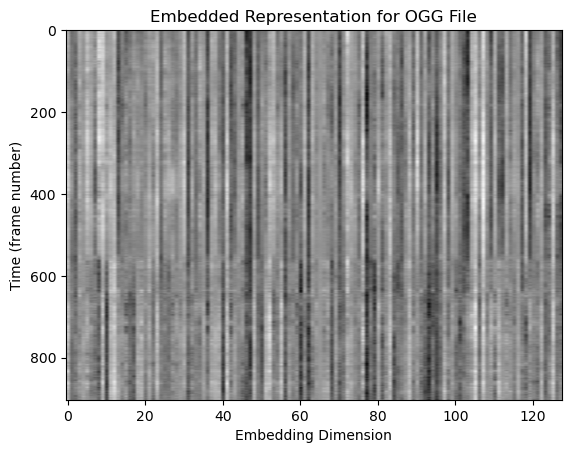

In [16]:
import matplotlib.pyplot as plt
plt.imshow(resdict['embedding'], 
           aspect='auto', cmap='binary')
plt.xlabel('Embedding Dimension')
plt.ylabel('Time (frame number)')
plt.title('Embedded Representation for OGG File')
plt.grid(False);

# Test out VGGish training mode (again :"))

In [1]:
ls

OpenMIC_input_VGGish.ipynb  __pycache__/     vggish_params.py
__init__.py                 vggish_input.py  vggish_slim.py


In [2]:
cd ..

/home/studio-lab-user/sagemaker-studiolab-notebooks/VGGish


In [3]:
from __future__ import print_function

from random import shuffle

import numpy as np
import tensorflow.compat.v1 as tf
import tf_slim as slim

import vggish_input
import vggish_params
import vggish_slim

2022-10-27 05:48:36.878606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 05:48:37.202501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-27 05:48:37.202528: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-27 05:48:37.235909: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-27 05:48:38.204582: W tensorflow/stream_executor/pla

In [4]:
flags = tf.app.flags

flags.DEFINE_integer(
    'num_batches', 3,
    'Number of batches of examples to feed into the model. Each batch is of '
    'variable size and contains shuffled examples of each class of audio.')

flags.DEFINE_boolean(
    'train_vggish', True,
    'If True, allow VGGish parameters to change during training, thus '
    'fine-tuning VGGish. If False, VGGish parameters are fixed, thus using '
    'VGGish as a fixed feature extractor.')

flags.DEFINE_string(
    'checkpoint', 'vggish_model.ckpt',
    'Path to the VGGish checkpoint file.')

FLAGS = flags.FLAGS

_NUM_CLASSES = 3

In [5]:
def _get_examples_batch():
  """Returns a shuffled batch of examples of all audio classes.

  Note that this is just a toy function because this is a simple demo intended
  to illustrate how the training code might work.

  Returns:
    a tuple (features, labels) where features is a NumPy array of shape
    [batch_size, num_frames, num_bands] where the batch_size is variable and
    each row is a log mel spectrogram patch of shape [num_frames, num_bands]
    suitable for feeding VGGish, while labels is a NumPy array of shape
    [batch_size, num_classes] where each row is a multi-hot label vector that
    provides the labels for corresponding rows in features.
  """
  # Make a waveform for each class.
  num_seconds = 5
  sr = 44100  # Sampling rate.
  t = np.arange(0, num_seconds, 1 / sr)  # Time axis
  # Random sine wave.
  freq = np.random.uniform(100, 1000)
  sine = np.sin(2 * np.pi * freq * t)
  # Random constant signal.
  magnitude = np.random.uniform(-1, 1)
  const = magnitude * t
  # White noise.
  noise = np.random.normal(-1, 1, size=t.shape)

  # Make examples of each signal and corresponding labels.
  # Sine is class index 0, Const class index 1, Noise class index 2.
  sine_examples = vggish_input.waveform_to_examples(sine, sr)
  sine_labels = np.array([[1, 0, 0]] * sine_examples.shape[0])
  const_examples = vggish_input.waveform_to_examples(const, sr)
  const_labels = np.array([[0, 1, 0]] * const_examples.shape[0])
  noise_examples = vggish_input.waveform_to_examples(noise, sr)
  noise_labels = np.array([[0, 0, 1]] * noise_examples.shape[0])

  # Shuffle (example, label) pairs across all classes.
  all_examples = np.concatenate((sine_examples, const_examples, noise_examples))
  all_labels = np.concatenate((sine_labels, const_labels, noise_labels))
  labeled_examples = list(zip(all_examples, all_labels))
  shuffle(labeled_examples)

  # Separate and return the features and labels.
  features = [example for (example, _) in labeled_examples]
  labels = [label for (_, label) in labeled_examples]
  print("finished processing data")
  return (features, labels)

In [22]:
hi = _get_examples_batch()

### hi is the examples batch tuple with a list of arrays and a list of labels

In [61]:
len(hi[0])

15

In [62]:
hi[0][0].shape

(96, 64)

In [63]:
hi[1]

[array([1, 0, 0]),
 array([1, 0, 0]),
 array([0, 1, 0]),
 array([0, 1, 0]),
 array([0, 1, 0]),
 array([0, 0, 1]),
 array([0, 0, 1]),
 array([0, 1, 0]),
 array([1, 0, 0]),
 array([0, 0, 1]),
 array([1, 0, 0]),
 array([0, 0, 1]),
 array([0, 1, 0]),
 array([0, 0, 1]),
 array([1, 0, 0])]

In [7]:
def main(_):
  with tf.Graph().as_default(), tf.Session() as sess:
    # Define VGGish.
    embeddings = vggish_slim.define_vggish_slim(training=FLAGS.train_vggish)

    # Define a shallow classification model and associated training ops on top
    # of VGGish.
    with tf.variable_scope('mymodel'):
      # Add a fully connected layer with 100 units. Add an activation function
      # to the embeddings since they are pre-activation.
      num_units = 100
      fc = slim.fully_connected(tf.nn.relu(embeddings), num_units)

      # Add a classifier layer at the end, consisting of parallel logistic
      # classifiers, one per class. This allows for multi-class tasks.
      logits = slim.fully_connected(
          fc, _NUM_CLASSES, activation_fn=None, scope='logits')
      tf.sigmoid(logits, name='prediction')

      # Add training ops.
      with tf.variable_scope('train'):
        global_step = tf.train.create_global_step()

        # Labels are assumed to be fed as a batch multi-hot vectors, with
        # a 1 in the position of each positive class label, and 0 elsewhere.
        labels_input = tf.placeholder(
            tf.float32, shape=(None, _NUM_CLASSES), name='labels')

        # Cross-entropy label loss.
        xent = tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=labels_input, name='xent')
        loss = tf.reduce_mean(xent, name='loss_op')
        tf.summary.scalar('loss', loss)

        # We use the same optimizer and hyperparameters as used to train VGGish.
        optimizer = tf.train.AdamOptimizer(
            learning_rate=vggish_params.LEARNING_RATE,
            epsilon=vggish_params.ADAM_EPSILON)
        #print(f"model set epoch
        train_op = optimizer.minimize(loss, global_step=global_step)

    # Initialize all variables in the model, and then load the pre-trained
    # VGGish checkpoint.
    sess.run(tf.global_variables_initializer())
    vggish_slim.load_vggish_slim_checkpoint(sess, FLAGS.checkpoint)

    # The training loop.
    features_input = sess.graph.get_tensor_by_name(
        vggish_params.INPUT_TENSOR_NAME)
    for _ in range(FLAGS.num_batches):
      (features, labels) = _get_examples_batch()
      [num_steps, loss_value, _] = sess.run(
          [global_step, loss, train_op],
          feed_dict={features_input: features, labels_input: labels})
      print('Step %d: loss %g' % (num_steps, loss_value))

In [8]:
!curl -O https://storage.googleapis.com/audioset/vggish_model.ckpt
!curl -O https://storage.googleapis.com/audioset/vggish_pca_params.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  277M  100  277M    0     0   130M      0  0:00:02  0:00:02 --:--:--  130M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73020  100 73020    0     0   713k      0 --:--:-- --:--:-- --:--:--  713k


In [9]:
if __name__ == '__main__':
  tf.app.run()

2022-10-27 05:50:02.875302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-27 05:50:02.875341: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-27 05:50:02.875377: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-10-27 05:50:02.878446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_l

INFO:tensorflow:Restoring parameters from vggish_model.ckpt


I1027 05:50:06.009806 140057292429120 saver.py:1410] Restoring parameters from vggish_model.ckpt


Step 0: loss 0.687599
Step 1: loss 0.659951
Step 2: loss 0.607468
Step 3: loss 0.599099
Step 4: loss 0.572809
Step 5: loss 0.555413
Step 6: loss 0.537134
Step 7: loss 0.538144
Step 8: loss 0.529852
Step 9: loss 0.490556
Step 10: loss 0.509996
Step 11: loss 0.495182
Step 12: loss 0.483333
Step 13: loss 0.467015
Step 14: loss 0.455899
Step 15: loss 0.424814
Step 16: loss 0.422491
Step 17: loss 0.412193
Step 18: loss 0.392472
Step 19: loss 0.371535
Step 20: loss 0.364371
Step 21: loss 0.355959
Step 22: loss 0.367308
Step 23: loss 0.335401
Step 24: loss 0.326684
Step 25: loss 0.337332
Step 26: loss 0.298309
Step 27: loss 0.29946
Step 28: loss 0.291302
Step 29: loss 0.281041
Step 30: loss 0.27244
Step 31: loss 0.260093


SystemExit: 

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3560: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Importing OpenMIC with labels

In [5]:
cd ..

/home/studio-lab-user/sagemaker-studiolab-notebooks


In [6]:
cd openmic-2018

/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018


In [7]:
import json
import os
import numpy as np
#!pip install pandas
import pandas as pd

In [8]:
data = np.load("openmic-2018.npz", allow_pickle = True)
X, Y_true, Y_mask, sample_key = data['X'], data['Y_true'], data['Y_mask'], data['sample_key']
print(X.shape, Y_true.shape, Y_mask.shape, sample_key.shape)

(20000, 10, 128) (20000, 20) (20000, 20) (20000,)


In [9]:
X[0].shape

(10, 128)

In [11]:
X[0][0]

array([173,  16, 162, 107, 197,  53, 155, 139, 149, 183, 157,  50, 130,
       104, 120,  96, 172, 113, 151, 159,  47, 238, 127,  83,  81, 201,
       143, 113, 238, 110, 145,  88, 157, 121,  63, 125, 146,  67, 106,
       150, 230, 213, 102, 185, 117, 188, 134, 112,  72, 135, 112, 125,
       131,  77, 162, 137,  78,  57, 130, 187, 146, 198,  52, 191, 211,
       187, 116,  97, 112, 148,  45, 231, 145, 202, 112, 148,  43, 255,
       220, 182, 143, 104, 213,  82,  61, 107, 114, 190, 162, 127, 140,
       125, 159, 216, 119, 176,  65,  66,  30, 132, 242, 176,  62,  89,
        95, 123, 106, 195, 172, 253, 168, 164,  82, 122, 163,  66,  87,
       124,   4, 139, 139,   0,  25,  44, 195,  42,  37, 255])

In [27]:
Y_true[8]

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0. ,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. ])

In [28]:
Y_mask[8]

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True])

In [29]:
sample_key[8]

'000182_145920'

# Create a _get_examples_batch using the function provided by the creators of VGGish

In [31]:
cd ..

/home/studio-lab-user/sagemaker-studiolab-notebooks


In [32]:
cd VGGish

/home/studio-lab-user/sagemaker-studiolab-notebooks/VGGish


In [33]:
!curl -O https://storage.googleapis.com/audioset/vggish_model.ckpt
!curl -O https://storage.googleapis.com/audioset/vggish_pca_params.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  277M  100  277M    0     0  56.0M      0  0:00:04  0:00:04 --:--:-- 61.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73020  100 73020    0     0   310k      0 --:--:-- --:--:-- --:--:--  308k


In [35]:
from __future__ import print_function

from random import shuffle

import numpy as np
import tensorflow.compat.v1 as tf
import tf_slim as slim

import vggish_input
import vggish_params
import vggish_slim

In [36]:
flags = tf.app.flags

flags.DEFINE_integer(
    'num_batches', 5,
    'Number of batches of examples to feed into the model. Each batch is of '
    'variable size and contains shuffled examples of each class of audio.')

flags.DEFINE_boolean(
    'train_vggish', True,
    'If True, allow VGGish parameters to change during training, thus '
    'fine-tuning VGGish. If False, VGGish parameters are fixed, thus using '
    'VGGish as a fixed feature extractor.')

flags.DEFINE_string(
    'checkpoint', 'vggish_model.ckpt',
    'Path to the VGGish checkpoint file.')

FLAGS = flags.FLAGS

_NUM_CLASSES = 20

In [48]:
def _get_examples_batch():
  """Returns a shuffled batch of examples of all audio classes.

  Returns:
    a tuple (features, labels) where features is a NumPy array of shape
    [batch_size, num_frames, num_bands] where the batch_size is variable and
    each row is a log mel spectrogram patch of shape [num_frames, num_bands]
    suitable for feeding VGGish, while labels is a NumPy array of shape
    [batch_size, num_classes] where each row is a multi-hot label vector that
    provides the labels for corresponding rows in features.
  """
  # Get file directory.
  file1 = "/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018/audio-ogg/000/000046_3840.ogg"
  file2 = "/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018/audio-ogg/000/000135_483840.ogg"
  file3 = "/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018/audio-ogg/000/000139_119040.ogg"

  # Make examples of each signal and corresponding labels.
  # Sine is class index 0, Const class index 1, Noise class index 2.
  file1_examples = vggish_input.wavfile_to_examples(file1)
  file1_labels = np.array([Y_true[0]] * file1_examples.shape[0])
  file2_examples = vggish_input.wavfile_to_examples(file2)
  file2_labels = np.array([Y_true[1]] * file2_examples.shape[0])
  file3_examples = vggish_input.wavfile_to_examples(file3)
  file3_labels = np.array([Y_true[2]] * file3_examples.shape[0])

  # Shuffle (example, label) pairs across all classes.
  all_examples = np.concatenate((file1_examples, file2_examples, file3_examples))
  all_labels = np.concatenate((file1_labels, file2_labels, file3_labels))
  labeled_examples = list(zip(all_examples, all_labels))
  
  print("finished processing data")
  return labeled_examples

In [46]:
def shuffle_data(labeled_examples):
    shuffle(labeled_examples)
    # Separate and return the features and labels.
    features = [example for (example, _) in labeled_examples]
    labels = [label for (_, label) in labeled_examples]
    print("finished shuffling data")
    return (features, labels)

In [43]:
def main(_):
  with tf.Graph().as_default(), tf.Session() as sess:
    # Define VGGish.
    embeddings = vggish_slim.define_vggish_slim(training=FLAGS.train_vggish)

    # Define a shallow classification model and associated training ops on top
    # of VGGish.
    with tf.variable_scope('mymodel'):
      # Add a fully connected layer with 100 units. Add an activation function
      # to the embeddings since they are pre-activation.
      num_units = 100
      fc = slim.fully_connected(tf.nn.relu(embeddings), num_units)

      # Add a classifier layer at the end, consisting of parallel logistic
      # classifiers, one per class. This allows for multi-class tasks.
      logits = slim.fully_connected(
          fc, _NUM_CLASSES, activation_fn=None, scope='logits')
      tf.sigmoid(logits, name='prediction')

      # Add training ops.
      with tf.variable_scope('train'):
        global_step = tf.train.create_global_step()

        # Labels are assumed to be fed as a batch multi-hot vectors, with
        # a 1 in the position of each positive class label, and 0 elsewhere.
        labels_input = tf.placeholder(
            tf.float32, shape=(None, _NUM_CLASSES), name='labels')

        # Cross-entropy label loss.
        xent = tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=labels_input, name='xent')
        loss = tf.reduce_mean(xent, name='loss_op')
        tf.summary.scalar('loss', loss)

        # We use the same optimizer and hyperparameters as used to train VGGish.
        optimizer = tf.train.AdamOptimizer(
            learning_rate=vggish_params.LEARNING_RATE,
            epsilon=vggish_params.ADAM_EPSILON)
        #print(f"model set epoch
        train_op = optimizer.minimize(loss, global_step=global_step)

    # Initialize all variables in the model, and then load the pre-trained
    # VGGish checkpoint.
    sess.run(tf.global_variables_initializer())
    vggish_slim.load_vggish_slim_checkpoint(sess, FLAGS.checkpoint)
    
    # create dataset
    labeled_examples = _get_examples_batch()

    # The training loop.
    features_input = sess.graph.get_tensor_by_name(
        vggish_params.INPUT_TENSOR_NAME)
    for _ in range(FLAGS.num_batches):
      # shuffle original dataset randomly for every epoch
      (features, labels) = shuffle_data(labeled_examples)
      [num_steps, loss_value, _] = sess.run(
          [global_step, loss, train_op],
          feed_dict={features_input: features, labels_input: labels})
      print('Step %d: loss %g' % (num_steps, loss_value))

In [49]:
if __name__ == '__main__':
  tf.app.run()

INFO:tensorflow:Restoring parameters from vggish_model.ckpt


I1029 04:09:02.457814 140611725608768 saver.py:1410] Restoring parameters from vggish_model.ckpt


finished processing data
finished shuffling data
Step 0: loss 0.702282
finished shuffling data
Step 1: loss 0.697097
finished shuffling data
Step 2: loss 0.693664
finished shuffling data
Step 3: loss 0.691319
finished shuffling data
Step 4: loss 0.689453


SystemExit: 

# Using all OpenMIC data for training

## Get time

In [87]:
from datetime import datetime

In [86]:
def get_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)

In [88]:
get_time()

Current Time = 12:49:07


## Get labels

In [5]:
cd ..

/home/studio-lab-user/sagemaker-studiolab-notebooks


In [6]:
cd openmic-2018

/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018


In [7]:
import json
import os
import numpy as np
#!pip install pandas
import pandas as pd

In [8]:
data = np.load("openmic-2018.npz", allow_pickle = True)
X, Y_true, Y_mask, sample_key = data['X'], data['Y_true'], data['Y_mask'], data['sample_key']
print(X.shape, Y_true.shape, Y_mask.shape, sample_key.shape)

(20000, 10, 128) (20000, 20) (20000, 20) (20000,)


## Training proper

In [31]:
cd ..

/home/studio-lab-user/sagemaker-studiolab-notebooks


In [32]:
cd VGGish

/home/studio-lab-user/sagemaker-studiolab-notebooks/VGGish


In [33]:
!curl -O https://storage.googleapis.com/audioset/vggish_model.ckpt
!curl -O https://storage.googleapis.com/audioset/vggish_pca_params.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  277M  100  277M    0     0  56.0M      0  0:00:04  0:00:04 --:--:-- 61.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73020  100 73020    0     0   310k      0 --:--:-- --:--:-- --:--:--  308k


In [35]:
from __future__ import print_function

from random import shuffle

import numpy as np
import tensorflow.compat.v1 as tf
import tf_slim as slim

import vggish_input
import vggish_params
import vggish_slim

In [36]:
flags = tf.app.flags

flags.DEFINE_integer(
    'num_batches', 5,
    'Number of batches of examples to feed into the model. Each batch is of '
    'variable size and contains shuffled examples of each class of audio.')

flags.DEFINE_boolean(
    'train_vggish', True,
    'If True, allow VGGish parameters to change during training, thus '
    'fine-tuning VGGish. If False, VGGish parameters are fixed, thus using '
    'VGGish as a fixed feature extractor.')

flags.DEFINE_string(
    'checkpoint', 'vggish_model.ckpt',
    'Path to the VGGish checkpoint file.')

FLAGS = flags.FLAGS

_NUM_CLASSES = 20

In [67]:
import os

folder = "/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018/audio-ogg"

# inputs folder path (e.g. audio-ogg folder) and outputs a list of file paths from the root
def get_ogg_files(folder_path):
    oggfilelist=[]
    for root, dir_names, file_names in os.walk(folder_path):
        # returns directory (e.g. folder 000) path from the root i.e. /home/
        # and file names
        for file in file_names:
            # append the full file name to the list
            full_name = root + "/" + file
            oggfilelist.append(full_name)
    # print(len(oggfilelist1))
    # print(oggfilelist1[0])
    return oggfilelist

In [68]:
folder1 = "/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018/audio-ogg"
hi = get_ogg_files(folder1)
print(len(hi))
print(hi[0])

20000
/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018/audio-ogg/000/000046_3840.ogg


In [89]:
def _get_examples_batch(folder):
  """Returns a shuffled batch of examples of all audio classes.

  Returns:
    a tuple (features, labels) where features is a NumPy array of shape
    [batch_size, num_frames, num_bands] where the batch_size is variable and
    each row is a log mel spectrogram patch of shape [num_frames, num_bands]
    suitable for feeding VGGish, while labels is a NumPy array of shape
    [batch_size, num_classes] where each row is a multi-hot label vector that
    provides the labels for corresponding rows in features.
  """
  # Get files from folder directory.
  files = get_ogg_files(folder)
  
  all_examples = []
  all_labels = []
  # Make examples from all ogg files and their respective labels obtained
  counter = 0
  for file in files:
      file_examples = vggish_input.wavfile_to_examples(file)
      file_labels = np.array([Y_true[counter]] * file_examples.shape[0])
      all_examples.append(file_examples)
      all_labels.append(file_labels)
      #print("file added")
      counter += 1

  # concatenate arrays in the original list
  all_examples = np.vstack(all_examples)
  all_labels = np.vstack(all_labels)
    
  # Shuffle (example, label) pairs across all classes.
  labeled_examples = list(zip(all_examples, all_labels))
  
  print("finished processing data")
  return labeled_examples

In [76]:
folder1 = "/home/studio-lab-user/sagemaker-studiolab-notebooks/openmic-2018/audio-ogg/000"
examples = _get_examples_batch(folder1)
print(examples[0][0])
print(examples[1][0])

file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added
file added

In [79]:
len(examples)

132

In [46]:
def shuffle_data(labeled_examples):
    shuffle(labeled_examples)
    # Separate and return the features and labels.
    features = [example for (example, _) in labeled_examples]
    labels = [label for (_, label) in labeled_examples]
    print("finished shuffling data")
    return (features, labels)

In [80]:
def main(_):
  with tf.Graph().as_default(), tf.Session() as sess:
    # Define VGGish.
    embeddings = vggish_slim.define_vggish_slim(training=FLAGS.train_vggish)

    # Define a shallow classification model and associated training ops on top
    # of VGGish.
    with tf.variable_scope('mymodel'):
      # Add a fully connected layer with 100 units. Add an activation function
      # to the embeddings since they are pre-activation.
      num_units = 100
      fc = slim.fully_connected(tf.nn.relu(embeddings), num_units)

      # Add a classifier layer at the end, consisting of parallel logistic
      # classifiers, one per class. This allows for multi-class tasks.
      logits = slim.fully_connected(
          fc, _NUM_CLASSES, activation_fn=None, scope='logits')
      tf.sigmoid(logits, name='prediction')

      # Add training ops.
      with tf.variable_scope('train'):
        global_step = tf.train.create_global_step()

        # Labels are assumed to be fed as a batch multi-hot vectors, with
        # a 1 in the position of each positive class label, and 0 elsewhere.
        labels_input = tf.placeholder(
            tf.float32, shape=(None, _NUM_CLASSES), name='labels')

        # Cross-entropy label loss.
        xent = tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits, labels=labels_input, name='xent')
        loss = tf.reduce_mean(xent, name='loss_op')
        tf.summary.scalar('loss', loss)

        # We use the same optimizer and hyperparameters as used to train VGGish.
        optimizer = tf.train.AdamOptimizer(
            learning_rate=vggish_params.LEARNING_RATE,
            epsilon=vggish_params.ADAM_EPSILON)
        #print(f"model set epoch
        train_op = optimizer.minimize(loss, global_step=global_step)

    # Initialize all variables in the model, and then load the pre-trained
    # VGGish checkpoint.
    sess.run(tf.global_variables_initializer())
    vggish_slim.load_vggish_slim_checkpoint(sess, FLAGS.checkpoint)
    
    # create dataset
    labeled_examples = _get_examples_batch(folder1)
    # print current time
    get_time()

    # The training loop.
    features_input = sess.graph.get_tensor_by_name(
        vggish_params.INPUT_TENSOR_NAME)
    for _ in range(FLAGS.num_batches):
      # shuffle original dataset randomly for every epoch
      (features, labels) = shuffle_data(labeled_examples)
      [num_steps, loss_value, _] = sess.run(
          [global_step, loss, train_op],
          feed_dict={features_input: features, labels_input: labels})
      get_time()
      print('Step %d: loss %g' % (num_steps, loss_value))

In [85]:
if __name__ == '__main__':
  tf.app.run()

INFO:tensorflow:Restoring parameters from vggish_model.ckpt


I1029 12:40:13.930780 140611725608768 saver.py:1410] Restoring parameters from vggish_model.ckpt


finished processing data
finished shuffling data


2022-10-29 12:41:07.605076: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2076180480 exceeds 10% of free system memory.
2022-10-29 12:41:08.652798: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 519045120 exceeds 10% of free system memory.
2022-10-29 12:41:08.936525: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1038090240 exceeds 10% of free system memory.
2022-10-29 12:41:10.671034: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 519045120 exceeds 10% of free system memory.
2022-10-29 12:41:12.048669: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 519045120 exceeds 10% of free system memory.


Step 0: loss 0.701833
finished shuffling data
Step 1: loss 0.700097
finished shuffling data
Step 2: loss 0.698753
finished shuffling data
Step 3: loss 0.697666
finished shuffling data
Step 4: loss 0.69671


SystemExit: 